In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import psycopg2
import warnings
warnings.filterwarnings('ignore')

In [2]:
file = open("db_login.txt", 'r')
logins = file.readlines()

for i, line in enumerate(logins):
    logins[i] = line.split('\n')[0]
    
file.close()

connect_params = {
     "host"      : logins[0],
     "database"  : logins[1],
     "user"      : logins[2],
     "password"  : logins[3]
}

In [3]:
def connect(conn_params):
    conn = None
    
    try:
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**conn_params)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1)
        
    print("Connection successful")
    
    return conn

In [4]:
conn = connect(connect_params)

Connecting to the PostgreSQL database...
Connection successful


In [5]:
def postgresql_to_dataframe(conn, select_query, column_headers):
    cursor = conn.cursor()
    
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    tuples = cursor.fetchall()
    cursor.close()
    
    df = pd.DataFrame(tuples, columns=column_headers)
    return df

## Candidates Database

#### Congressional Candidates

In [ ]:
# All Congressional Candidates
query1 = """
SELECT cycle, cid, first_last_party, party, dist_id_run_for, current_candidate, cycle_candidate, recip_code,
raised_from_pacs, raised_from_individuals, raised_total, raised_unitemized
FROM candidates
WHERE dist_id_run_for NOT LIKE 'PRES' AND dist_id_run_for NOT LIKE '__S_'
"""

In [ ]:
col_names_1 = ['cycle', 'id', 'candidate_name', 'party', 'district', 'current_candidate', 'cycle_candidate',
               'recip_code', 'raised_from_pacs', 'raised_from_individuals', 'raised_total', 'raised_unitemized']

In [ ]:
all_congr_candids = postgresql_to_dataframe(conn, query1, col_names_1)
all_congr_candids

In [ ]:
# Insert State Column
congr_states = [state[:2] for state in all_congr_candids['district']]
all_congr_candids.insert(4, 'state', congr_states)

# Extract Just District Number
districts = [state[-2:] for state in all_congr_candids['district']]
all_congr_candids['district'] = districts

# Remove Party Affliation from Name
all_congr_candids['candidate_name'] = [name[:-4] for name in all_congr_candids['candidate_name']]

In [ ]:
all_congr_candids.head()

#### Senate Candidates

In [ ]:
# All Senate Candidates
query2 = """
SELECT cycle, cid, first_last_party, party, dist_id_run_for, current_candidate, cycle_candidate, recip_code,
raised_from_pacs, raised_from_individuals, raised_total, raised_unitemized
FROM candidates
WHERE dist_id_run_for NOT LIKE 'PRES' AND dist_id_run_for LIKE '__S_'
"""

In [ ]:
col_names_2 = ['cycle', 'id', 'candidate_name', 'party', 'district', 'current_candidate', 'cycle_candidate',
               'recip_code', 'raised_from_pacs', 'raised_from_individuals', 'raised_total', 'raised_unitemized']

In [ ]:
all_sen_candids = postgresql_to_dataframe(conn, query2, col_names_2)
all_sen_candids

In [ ]:
# Insert State Column
sen_states = [state[:2] for state in all_sen_candids['district']]
all_sen_candids.insert(4, 'state', sen_states)

# Replace all District Numbers with Null Values
all_sen_candids['district'] = [np.nan for district in all_sen_candids['district']]

# Remove Party Affliation from Name
all_sen_candids['candidate_name'] = [name[:-4] for name in all_sen_candids['candidate_name']]

In [ ]:
all_sen_candids.head()

In [ ]:
# Append both House and Senate Candidate Info
all_candidates = all_congr_candids.append(all_sen_candids)
all_candidates

In [ ]:
# Exclude any candidates from U.S. Territories
us_territories = ['AS', 'GU', 'MH', 'MP', 'PR', 'Pr', 'VI']
boolean_filter = ~all_candidates.state.isin(us_territories)
all_CONUS_candidates = all_candidates[boolean_filter]
all_CONUS_candidates

In [ ]:
all_CONUS_candidates.to_csv('../data/all_CONUS_candidates.csv', index=False)

---
# Individual Donations Database

In [ ]:
cycle = 1990

#### Senate Campaigns

In [ ]:
# All Senate Individual Donations
query3 = """
SELECT DISTINCT(i.fec_trans_id), i.cycle, i.date_donated, i.recipient_id, i.contributor_id, i.contributor_name,
i.org_name, i.ult_org, i.amount, i.city, i.state, i.recip_code, i.type, i.gender, i.occupation, i.employer
FROM individual_contributions AS i
INNER JOIN candidates AS c on i.recipient_id = c.cid
WHERE i.cycle="""+str(cycle)+""" AND i.recipient_id LIKE 'N%' AND
c.dist_id_run_for NOT LIKE 'PRES' AND c.dist_id_run_for LIKE '__S_'
"""

In [ ]:
col_names_3 = ['transaction_id', 'cycle', 'date', 'recipient_id', 'contributor_id', 'contributor_name',
               'org_name', 'ult_org', 'amount', 'city', 'state', 'recip_code', 'type',
               'gender', 'occupation', 'employer']

In [ ]:
df1 = postgresql_to_dataframe(conn, query3, col_names_3)
df1.head(5)

In [ ]:
df1.to_csv('../data/individual_contributions/senate/sen_'+str(cycle)+'_individ_donations.csv', index=False)

#### Congressional Campaigns

In [ ]:
# All Congressional Individual Donations
query4 = """
SELECT DISTINCT(i.fec_trans_id), i.cycle, i.date_donated, i.recipient_id, i.contributor_id, i.contributor_name, i.org_name,
i.ult_org, i.amount, i.city, i.state, i.recip_code, i.type, i.gender, i.occupation, i.employer
FROM individual_contributions AS i
INNER JOIN candidates AS c on i.recipient_id = c.cid
WHERE i.cycle="""+str(cycle)+""" AND i.recipient_id LIKE 'N%' AND
c.dist_id_run_for NOT LIKE 'PRES' AND c.dist_id_run_for NOT LIKE '__S_'
"""

In [ ]:
df2 = postgresql_to_dataframe(conn, query4, col_names_3)
df2.tail(5)

In [ ]:
df2.to_csv('../data/individual_contributions/house/congr_'+str(cycle)+'_individ_donations.csv', index=False)

---
# PAC Donations

In [ ]:
cycle = 2016

In [ ]:
# All PAC Donations
query5 = """
SELECT p.cycle, p.date_donated, p.pac_id, r.pac_short, p.amount, p.cid, p.real_code, p.type, r.recip_code, p.di
FROM pacs AS p
INNER JOIN pac_records AS r ON p.pac_id = r.committee_id
WHERE p.cycle = """+str(cycle)

In [ ]:
col_names_5 = ['cycle', 'date_donated', 'pac_id', 'pac_name', 'amount', 'candidate_id', 'industry_code',
               'type', 'recip_code', 'direct']

In [ ]:
df3 = postgresql_to_dataframe(conn, query5, col_names_5)
df3

In [ ]:
df3.to_csv('../data/pacs/'+str(cycle)+'_pac_donations.csv', index=False)

In [6]:
conn.close()

---
# Total Number of Records per Database

In [7]:
pacs_2014 = pd.read_csv('../data/pacs/2014_pac_donations.csv')
pacs_2012 = pd.read_csv('../data/pacs/2012_pac_donations.csv')
pacs_2010 = pd.read_csv('../data/pacs/2010_pac_donations.csv')
pacs_2008 = pd.read_csv('../data/pacs/2008_pac_donations.csv')
pacs_2006 = pd.read_csv('../data/pacs/2006_pac_donations.csv')
pacs_2004 = pd.read_csv('../data/pacs/2004_pac_donations.csv')
pacs_2002 = pd.read_csv('../data/pacs/2002_pac_donations.csv')
pacs_2000 = pd.read_csv('../data/pacs/2000_pac_donations.csv')

In [8]:
sen_2014 = pd.read_csv('../data/individual_contributions/senate/sen_2014_individ_donations.csv')
sen_2012 = pd.read_csv('../data/individual_contributions/senate/sen_2012_individ_donations.csv')
sen_2010 = pd.read_csv('../data/individual_contributions/senate/sen_2010_individ_donations.csv')
sen_2008 = pd.read_csv('../data/individual_contributions/senate/sen_2008_individ_donations.csv')
sen_2006 = pd.read_csv('../data/individual_contributions/senate/sen_2006_individ_donations.csv')
sen_2004 = pd.read_csv('../data/individual_contributions/senate/sen_2004_individ_donations.csv')
sen_2002 = pd.read_csv('../data/individual_contributions/senate/sen_2002_individ_donations.csv')
sen_2000 = pd.read_csv('../data/individual_contributions/senate/sen_2000_individ_donations.csv')

In [9]:
congr_2014 = pd.read_csv('../data/individual_contributions/house/congr_2014_individ_donations.csv')
congr_2012 = pd.read_csv('../data/individual_contributions/house/congr_2012_individ_donations.csv')
congr_2010 = pd.read_csv('../data/individual_contributions/house/congr_2010_individ_donations.csv')
congr_2008 = pd.read_csv('../data/individual_contributions/house/congr_2008_individ_donations.csv')
congr_2006 = pd.read_csv('../data/individual_contributions/house/congr_2006_individ_donations.csv')
congr_2004 = pd.read_csv('../data/individual_contributions/house/congr_2004_individ_donations.csv')
congr_2002 = pd.read_csv('../data/individual_contributions/house/congr_2002_individ_donations.csv')
congr_2000 = pd.read_csv('../data/individual_contributions/house/congr_2000_individ_donations.csv')

In [10]:
# Combine data from each cycle into one comprehensive DataFrame
pac_records = [
    pacs_2014, pacs_2012, pacs_2010, pacs_2008, pacs_2006, pacs_2004, pacs_2002, pacs_2000]
num_pac_records = [round(data.shape[0]/1_000_000, 2) for data in pac_records]

congr_records = [
    congr_2014, congr_2012, congr_2010, congr_2008, congr_2006, congr_2004, congr_2002, congr_2000]
num_congr_records = [round(data.shape[0]/1_000_000, 2) for data in congr_records]

sen_records = [
    sen_2014, sen_2012, sen_2010, sen_2008, sen_2006, sen_2004, sen_2002, sen_2000]
num_sen_records = [round(data.shape[0]/1_000_000, 2) for data in sen_records]

In [11]:
years = ['14', '12', '10', '08', '06', '04', '02', '00']
all_records = pd.DataFrame(num_sen_records, columns=['Senate'], index=years)
all_records['Congress'] = pd.DataFrame(num_congr_records, columns=['Congress'], index=years)
all_records['PACs'] = pd.DataFrame(num_pac_records, columns=['PACs'], index=years)
all_records

,Senate,Congress,PACs
14,0.46,0.79,0.30
12,1.63,1.64,0.39
10,0.61,0.96,0.32
08,1.73,1.49,0.30
06,0.51,0.77,0.27
04,0.72,0.66,0.25
02,0.41,0.57,0.24
00,0.56,0.60,0.25


In [12]:
# Millions of records per category
all_records.sum()

Senate      6.63
Congress    7.48
PACs        2.32
dtype: float64

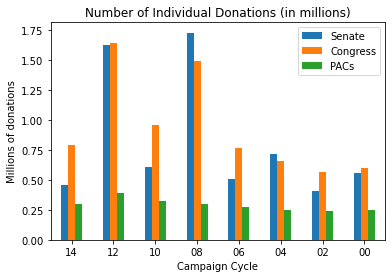

In [13]:
all_records.plot(kind='bar')
plt.xticks(rotation = 0)
plt.title("Number of Individual Donations (in millions)")
plt.ylabel("Millions of donations")
plt.xlabel("Campaign Cycle")
plt.legend();